# Self Driving Cars Nanodegree

# Project: Finding Lane Lines on the Road

# Reflection

My pipeline consisted of following steps:
1. Read the image from the camera
2. Blur the image using Gaussian blur to remove color
3. Apply mask to find the region of interest (ROI)
4. Color the ROI
5. Detect Edges using the Canny Algorithm
6. Color the Edges using Hough Transform
7. Draw line segments by color only the ROI using Hough Transform
8. Extrapolate line segments to determine lanes

The image below shows the code pipeline.

In [3]:
from IPython.core.display import Image
Image(filename='/images_raw/Pipeline.png')

FileNotFoundError: [Errno 2] No such file or directory: '/images_raw/Pipeline.png'

The following section shows the code for each step:

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 #Including OpenCV libraries
import os
import math

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
    
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image

    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def mean(numbers):
    return float(sum(numbers) / len(numbers))

def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    
    imshape = img.shape
  
    leftLaneSlopeArray = []
    leftLaneInterceptArray = []
    rightLaneSlopeArray = []
    rightLaneInterceptArray = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #PolyFit function of Numpy gives you slope and intercept
            slope, intercept = np.polyfit((x1,x2), (y1,y2), 1)
            #print(slope, intercept)
            
            if (slope > 0):
                leftLaneSlopeArray += [slope]
                leftLaneInterceptArray += [intercept]
            else:
                rightLaneSlopeArray += [slope]
                rightLaneInterceptArray += [intercept]

    '''
    print (leftLaneSlopeArray)
    print (leftLaneInterceptArray)
    
    print (rightLaneSlopeArray)
    print (rightLaneInterceptArray)
    '''
    
    leftLaneSlopeArrayAverage = np.mean(leftLaneSlopeArray)
    leftLaneInterceptArrayAverage = np.mean(leftLaneInterceptArray)
    
    rightLaneSlopeArrayAverage = np.mean(rightLaneSlopeArray)
    rightLaneInterceptArrayAverage = np.mean(rightLaneInterceptArray)
    
    #   y = mx + b
    #   x = (y - b)/m
    #   b = y - mx

    yMin = 0
    yMax = image.shape[0]
    
    yMin = 325
    yMax = image.shape[0]
    
    #print(yMin, yMax, leftLaneSlopeArrayAverage, leftLaneInterceptArrayAverage, rightLaneSlopeArrayAverage, rightLaneInterceptArrayAverage)

    #yMin=360 
    #yMax=540 
    #leftLaneSlopeArrayAverage=2.41568391496e-15 
    #leftLaneInterceptArrayAverage=508.0 
    #rightLaneSlopeArrayAverage=-0.618339899623 
    #rightLaneInterceptArrayAverage=628.920102703

    try:
        x1Left = int(np.nan_to_num(float((yMin-leftLaneInterceptArrayAverage)/leftLaneSlopeArrayAverage)))
        x2Left = int(np.nan_to_num(float((yMax-leftLaneInterceptArrayAverage)/leftLaneSlopeArrayAverage)))
        cv2.line(img, (x1Left, yMin), (x2Left, yMax), color, thickness)
    except ValueError:
        pass
    except OverflowError:
        pass
    
    try:
        x1Right = int(np.nan_to_num(float((yMin-rightLaneInterceptArrayAverage)/rightLaneSlopeArrayAverage)))
        x2Right = int(np.nan_to_num(float((yMax-rightLaneInterceptArrayAverage)/rightLaneSlopeArrayAverage)))
        cv2.line(img, (x1Right, yMin), (x2Right, yMax), color, thickness)
    except ValueError:
        pass
    except OverflowError:
        pass
    
    #print ("x1Left", x1Left, "x2Left", x2Left, "x1Right", x1Right, "x2Right", x2Right)
    #x1Left -61266293608840008 x2Left 13246766185695422 x1Right 434 x2Right 143

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, a=0.8, b=1., g=0.):
    return cv2.addWeighted(initial_img, a, img, b, g)

In [4]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    #printing out some states and plotting
    #print('The image is:', type(image), 'with dimensions"', image.shape)

    gray_image = grayscale(image)

    kernel_size = 5
    blurred_gray_image = gaussian_blur(gray_image,kernel_size)

    low_threshold = 50
    high_threshold = 150

    cannyEdge_image = canny(blurred_gray_image, low_threshold, high_threshold)

    xMin = 0
    yMin = 0
    xMax = image.shape[1]
    yMax = image.shape[0]
    yLen = 360
    #print(xMin, xMax, yMin, yMax, yLen)
    
    bottom_left = [xMin,yMax]
    top_left = [415,360]
    top_right = [575,yLen]
    bottom_right = [xMax,yMax]
    '''
    bottom_left = [115,540]
    top_left = [415,360]
    top_right = [575,360]
    bottom_right = [900,540]
    '''

    vertices = np.array([[bottom_left,top_left, top_right, bottom_right]], dtype=np.int32)
    #print(vertices)

    masked_image = region_of_interest(cannyEdge_image, vertices)

    rho = 1
    theta = np.pi/180
    threshold = 1
    min_line_length = 40
    max_line_gap = 20

    #Create a blank image to draw lines on
    #BlankLine_image = np.copy(image)*0 
    #houghLine_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    houghLine_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
               
    #lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    #line_image = np.zeros((masked_image.shape[0], masked_image.shape[1], 3),dtype=np.uint8)
    '''
    coloredBinary_image = np.dstack((cannyEdge_image,cannyEdge_image,cannyEdge_image))
    weightedImage =cv2.addWeighted(coloredBinary_image, 0.8, houghLine_image, 1, 0)

    houghLine_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    #Create a color binary image to combine with Line Image
    coloredBinary_image = np.dstack((cannyEdge_image, cannyEdge_image, cannyEdge_image))
    #plt.imshow(coloredBinary_image) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

    #Draw the lines on the edge images
    weightedImage = cv2.addWeighted(coloredBinary_image, 0.8, blankLine_image, 1, 0)
    '''
    #houghLine_image_in_ROI = region_of_interest(houghLine_image, vertices)
    
    result = weighted_img(houghLine_image, image)

    return result

In [5]:
rootdir = "test_images/"
os.listdir(rootdir)

['.DS_Store',
 'exit-ramp.jpg',
 'lane_on_solidWhiteCurve.png',
 'lane_on_solidWhiteRight.png',
 'lane_on_solidYellowCurve.png',
 'lane_on_solidYellowCurve2.png',
 'lane_on_solidYellowLeft.png',
 'lane_on_whiteCarLaneSwitch.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

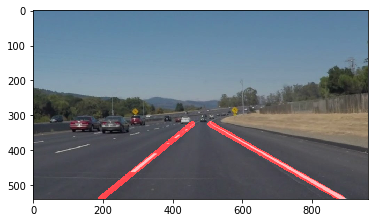

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
final_image = process_image(image)
plt.imshow(final_image) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

plt.savefig('test_images/lane_on_solidWhiteCurve.png')
plt.show()

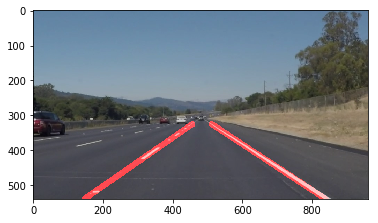

In [7]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
final_image = process_image(image)
plt.imshow(final_image) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

plt.savefig('test_images_output/lane_on_solidWhiteRight.png')
plt.show()

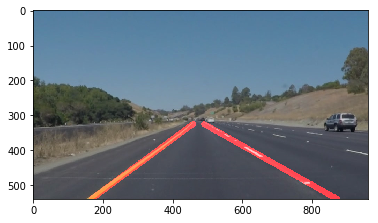

In [8]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')
final_image = process_image(image)
plt.imshow(final_image) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

plt.savefig('test_images/lane_on_solidYellowCurve.png')
plt.show()

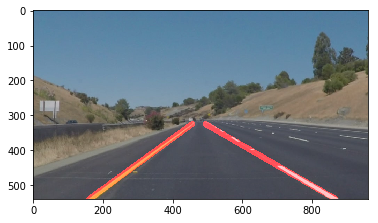

In [9]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
final_image = process_image(image)
plt.imshow(final_image) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

plt.savefig('test_images/lane_on_solidYellowCurve2.png')
plt.show()

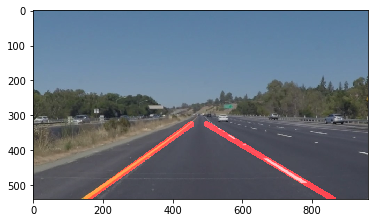

In [10]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')
final_image = process_image(image)
plt.imshow(final_image) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

plt.savefig('test_images/lane_on_solidYellowLeft.png')
plt.show()

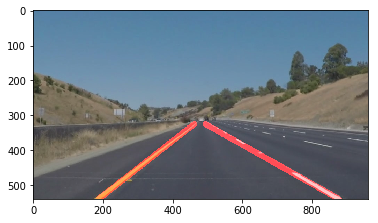

In [11]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
final_image = process_image(image)
plt.imshow(final_image) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

plt.savefig('test_images/lane_on_whiteCarLaneSwitch.png')
plt.show()

# Drawing lanes over video

In [12]:
import imageio
imageio.plugins.ffmpeg.download()

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    
    gray_image = grayscale(image)
    
    kernel_size = 5
    blurred_gray_image = gaussian_blur(gray_image,kernel_size)

    low_threshold = 50
    high_threshold = 150
    cannyEdge_image = canny(blurred_gray_image, low_threshold, high_threshold)

    xMin = 0
    yMin = 0
    xMax = image.shape[1]
    yMax = image.shape[0]
    yLen = 360
    #print(xMin, xMax, yMin, yMax, yLen)
    
    bottom_left = [xMin,yMax]
    top_left = [415,360]
    top_right = [575,yLen]
    bottom_right = [xMax,yMax]
    '''
    bottom_left = [115,540]
    top_left = [415,360]
    top_right = [575,360]
    bottom_right = [900,540]
    '''

    vertices = np.array([[bottom_left,top_left, top_right, bottom_right]], dtype=np.int32)
    #print(vertices)

    masked_image = region_of_interest(cannyEdge_image, vertices)

    rho = 1
    theta = np.pi/180
    threshold = 1
    min_line_length = 40
    max_line_gap = 20

    houghLine_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    result = weighted_img(houghLine_image, image)

    return result
    return result
# Implemented above (reusing same function)

In [15]:
whiteLanesVideo = 'test_videos/whiteLanes_extrapolations.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(whiteLanesVideo, audio=False)

[MoviePy] >>>> Building video whiteLanes_extrapolations.mp4
[MoviePy] Writing video whiteLanes_extrapolations.mp4


100%|█████████▉| 221/222 [00:03<00:00, 73.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: whiteLanes_extrapolations.mp4 

CPU times: user 2.56 s, sys: 687 ms, total: 3.25 s
Wall time: 3.39 s


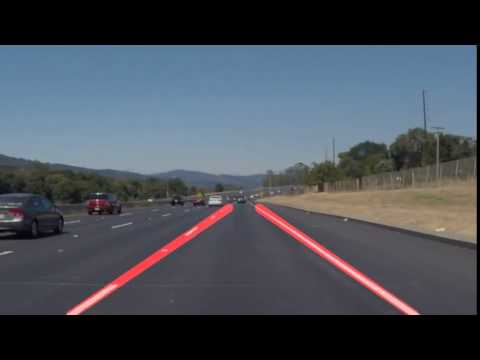

In [19]:
#Had an issue rendering the video output inline using HTML embedding and
#so uploaded the video to Youtube Channel and linked it here. 

from IPython.display import YouTubeVideo
YouTubeVideo("92I2CRG3foE")

In [17]:
yellowLanesVideo = 'test_videos/yellowLanes_extrapolations.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(yellowLanesVideo, audio=False)

[MoviePy] >>>> Building video yellowLanes_extrapolations.mp4
[MoviePy] Writing video yellowLanes_extrapolations.mp4


100%|█████████▉| 681/682 [00:09<00:00, 72.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellowLanes_extrapolations.mp4 

CPU times: user 8 s, sys: 1.98 s, total: 9.98 s
Wall time: 9.78 s


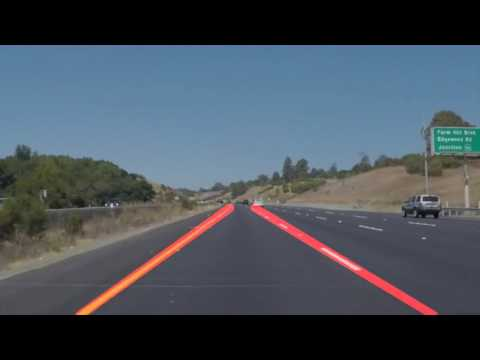

In [20]:
YouTubeVideo("qsnpv8Cx_0g")

# Potential Shortcomings

Each image is being loaded individually and processed.

The low and high threshold for edge detection using Canny Transform is hardcoded and specified which may not work in all situations (inclement weather can make lighting and image edges difficult to detect).

Additionally, the top_left and top_right for determining the region of interest is hardcoded as well which may or may not work with different image resolutions from different cameras.

# Suggested Improvements

Loop through the images and proceess each instead of manually loading and processing them one at a time.

Automate the determination of the thresholds for canny edge detection (possibly using deep neural networks).

Determine the region of interest dynamically by taking a percentage of the image that we can use as the the field of view for the camera.

In the process_image function, handle the ValueError and OverflowError when the data does not fit the processing function.